In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.dft import *
import glob
#import scipy as sp

import matplotlib.pyplot as plt
feos_pcsaft.__file__

'/home/bursik/anaconda3/envs/conda_pcsaft/lib/python3.10/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

# Local DFT Implementation

In [2]:
components = ['hexane']#, 'pentane']
composition = np.array([0.3, 0.7]) *MOL
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [3]:
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')
func = PcSaftFunctional(params)
func_hs = (params)


In [4]:
# np.savetxt('rho_398K.dat', interface.density*NAV*ANGSTROM**3, header="density")

In [5]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)
vle

||temperature|density|
|-|-|-|
|phase 1|298.15 K|8.23411069162512  mol/m³|
|phase 2|298.15 K|7.537249518083163 kmol/m³|


In [25]:
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=30, log=True)#.picard_iteration(tol=1.0e-5, beta=0.01, max_iter=10).anderson_mixing(tol=1.0e-9,mmax=10)# # just write after one another
# solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=10, max_iter=50, beta=0.05)# # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 100 * ANGSTROM, t_crit, local_flag=2)
#print(f'max density = {max(interface.density/MOL*METER**3)}' ) 
density_init = interface.density

Version with total moles


In [26]:
interface.functional_derivative_fft-interface.functional_derivative

 Called fn weighted_densities in GradConvolver


array([[ 6.48370246e-14,  6.66133815e-14,  6.57252031e-14, ...,
        -9.94759830e-13, -9.80548975e-13, -9.76996262e-13]])

 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver


 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver


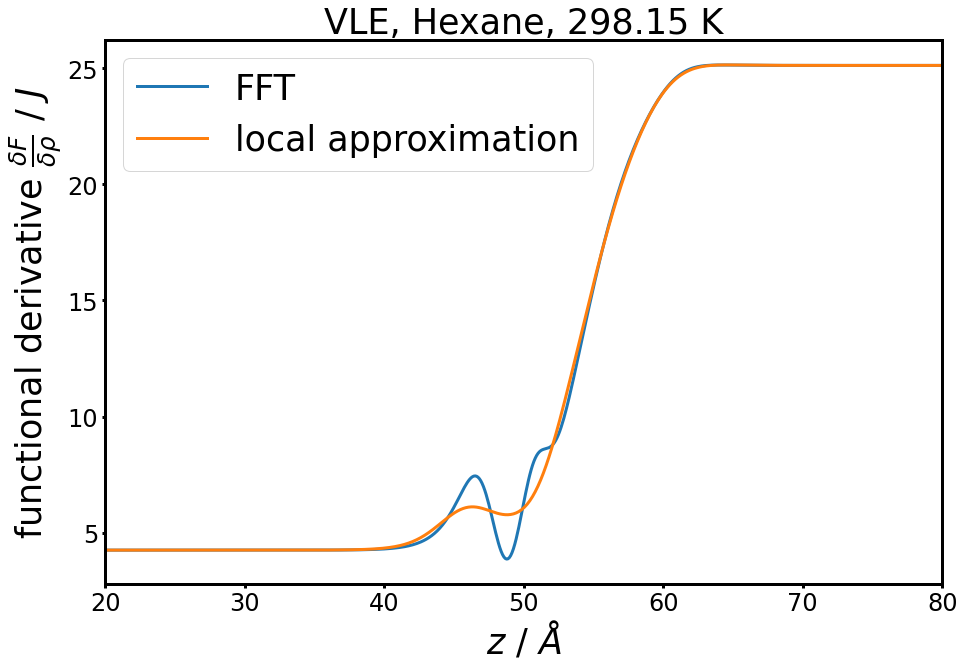

In [27]:
fig = plt.figure(figsize=[15,10])
fontsize=35
ax = plt.gca()
plt.plot(interface.z/ANGSTROM, interface.functional_derivative_fft[0,:], label=f'FFT', linewidth=3)#, linestyle='--')#, marker='x')
plt.plot(interface.z/ANGSTROM, interface.functional_derivative[0,:], label=f'local approximation', linewidth=3)
plt.xlim([20,80])
plt.title(f'VLE, Hexane, {temperature/KELVIN} K', fontsize=fontsize)
plt.ylabel(r'functional derivative $\frac{\delta F}{\delta \rho}$ / $J$', fontsize=fontsize)
plt.xlabel(r'$z$ / $\AA$', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=20)

# props = dict(facecolor='None')
# plt.text(0.63, 0.9, s='---  FFT \n__  local approximation', transform=ax.transAxes, fontsize=25, bbox=props)
# plt.text(0.65, 0.84,s='__  local approximation', transform=ax.transAxes, fontsize=25)
plt.savefig('fd_init_DFTvslocal_298K_font.png')
# plt.savefig('.png')

called fn weighted densities in FFT convolver
 Called fn weighted_densities in GradConvolver


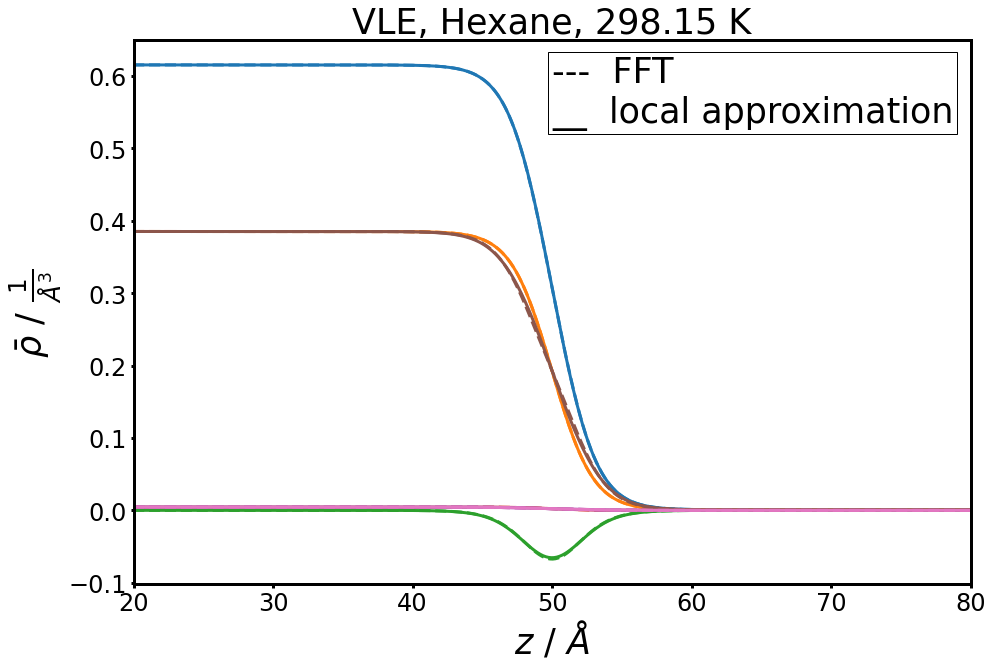

In [30]:
fig = plt.figure(figsize=[15,10])
fontsize=35
ax = plt.gca()
for wds, wdsfft in zip(interface.weighted_densities, interface.weighted_densities_FFT):
    for i in range(len(wds)):
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(interface.z/ANGSTROM, wds[i,:], label=f'local wd, {i}', color=color, linewidth=3)
        plt.plot(interface.z/ANGSTROM, wdsfft[i,:], label=f'FFT wd, {i}',color=color, linestyle='--', linewidth=3)#, marker='x')
plt.xlim([20,80])
plt.title(f'VLE, Hexane, {temperature/KELVIN} K', fontsize=fontsize)
plt.ylabel(r'$\bar{\rho}$ / $\frac{1}{\AA^3}$', fontsize=fontsize)
plt.xlabel(r'$z$ / $\AA$', fontsize=fontsize)
# plt.legend()

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=20)

props = dict(facecolor='None')
plt.text(0.5, 0.85, s='---  FFT \n__  local approximation', transform=ax.transAxes, fontsize=fontsize, bbox=props)
# plt.text(0.65, 0.84,s='__  local approximation', transform=ax.transAxes, fontsize=25)
plt.savefig('wd_init_DFTvslocal_298K_font.png')
# plt.savefig('?.png')

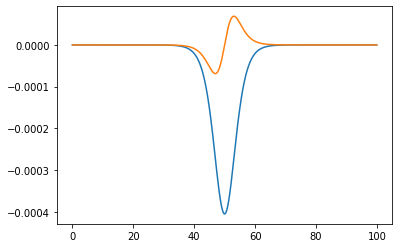

In [29]:
for filename in glob.glob('*grad_rho.npy'):
    data = np.load(filename)    
    for j in range(data.shape[0]):
        plt.plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')#, marker = 'x')
        # print(i)


for filename in glob.glob('*lapl_rho.npy'):
    data = np.load(filename)    
    for j in range(data.shape[0]):
        plt.plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')#, marker = 'x')
        # print(i)


Version with total moles
calling initial solve
solver               | iter | residual 
-------------------------------------------
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver
 Called fn weighted_densities in GradConvolver
calling solve picard
solver               | iter | residual 
-------------------------------------------
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver
Picard iteration     |    1 | 3.633400e-4 | 0.01
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver
Picard iteration     |    2 | 3.451870e-4 | 0.01
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver
Picard iteration     |    3 | 3.280311e-4 | 0.01
 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver
 Called fn weighted_densities in GradConvolver
calling solve
solver               | iter | residual 
----

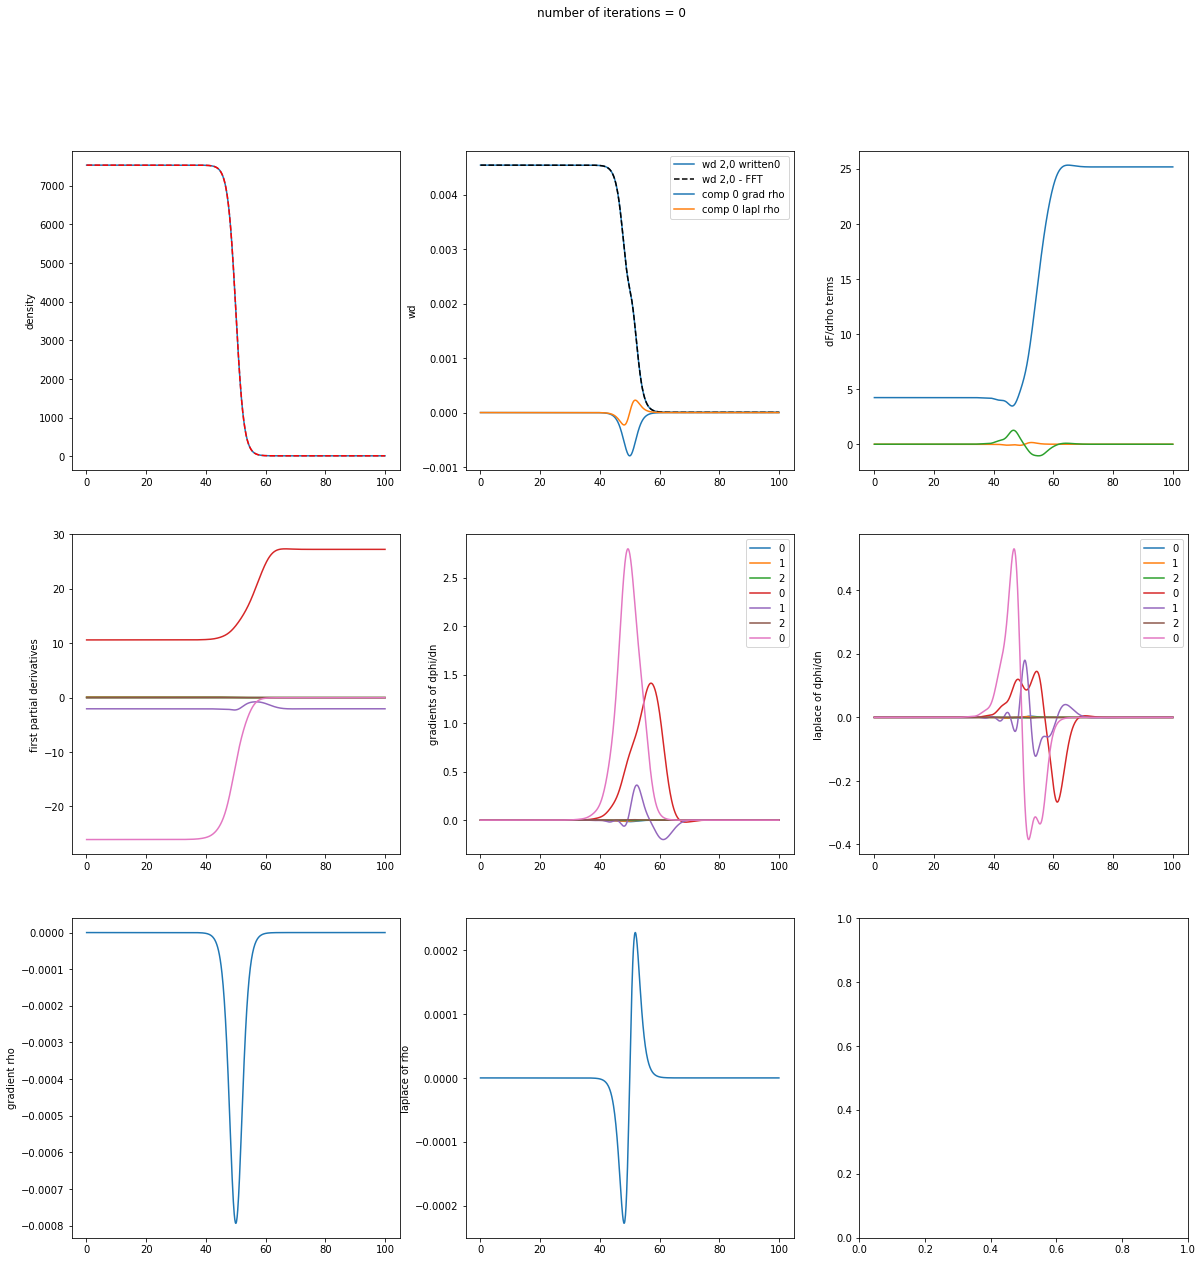

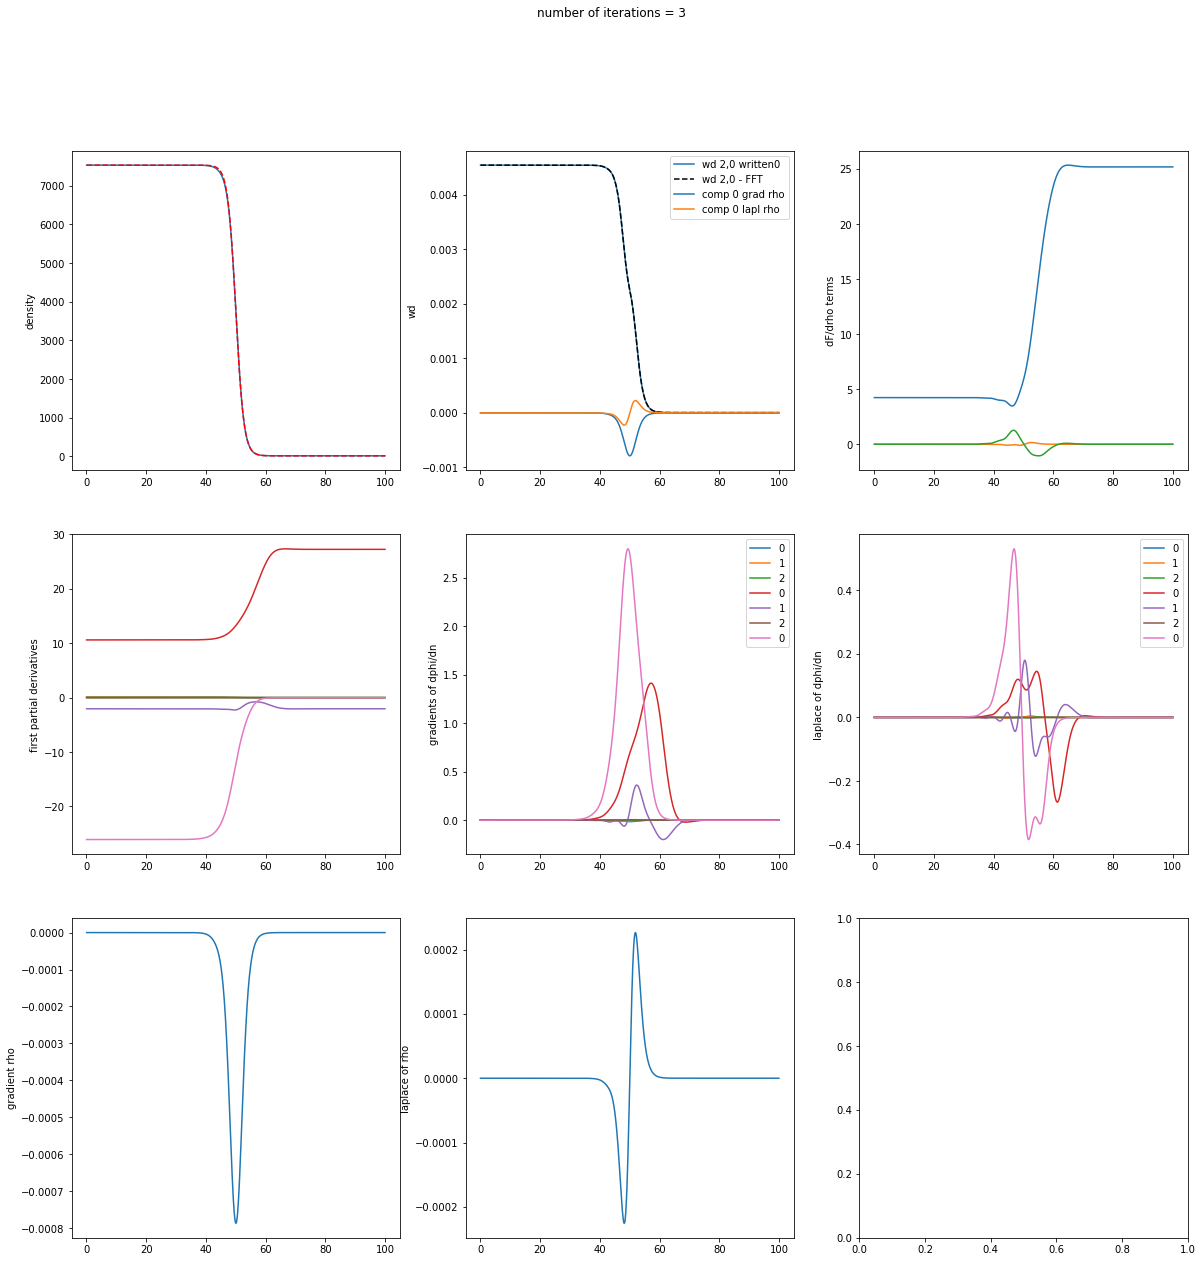

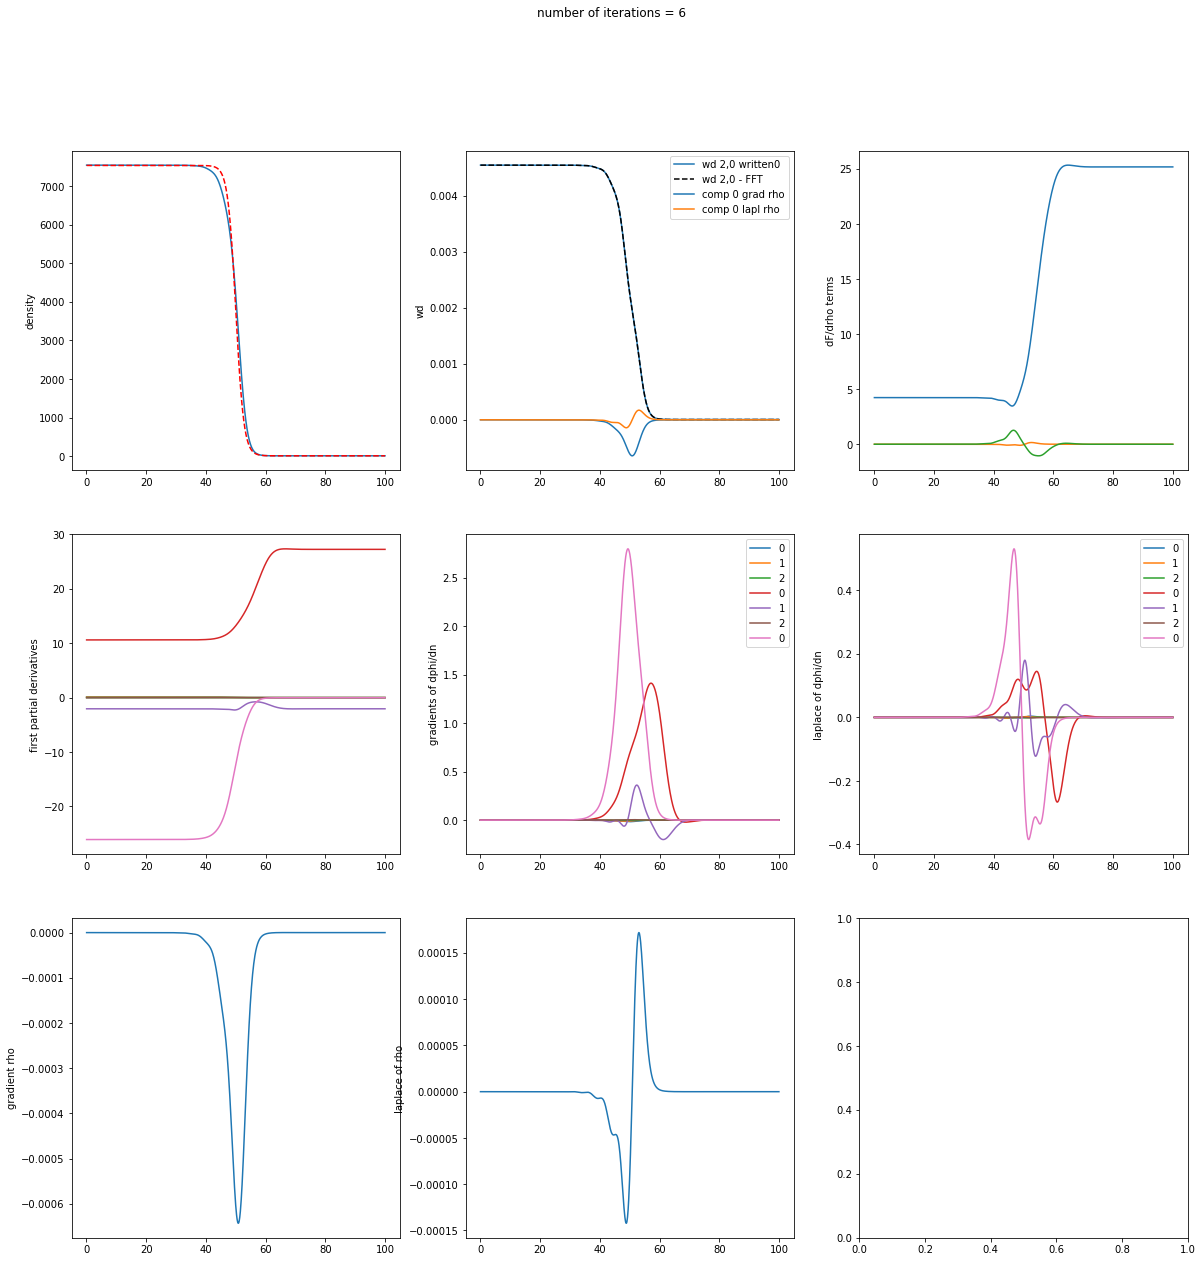

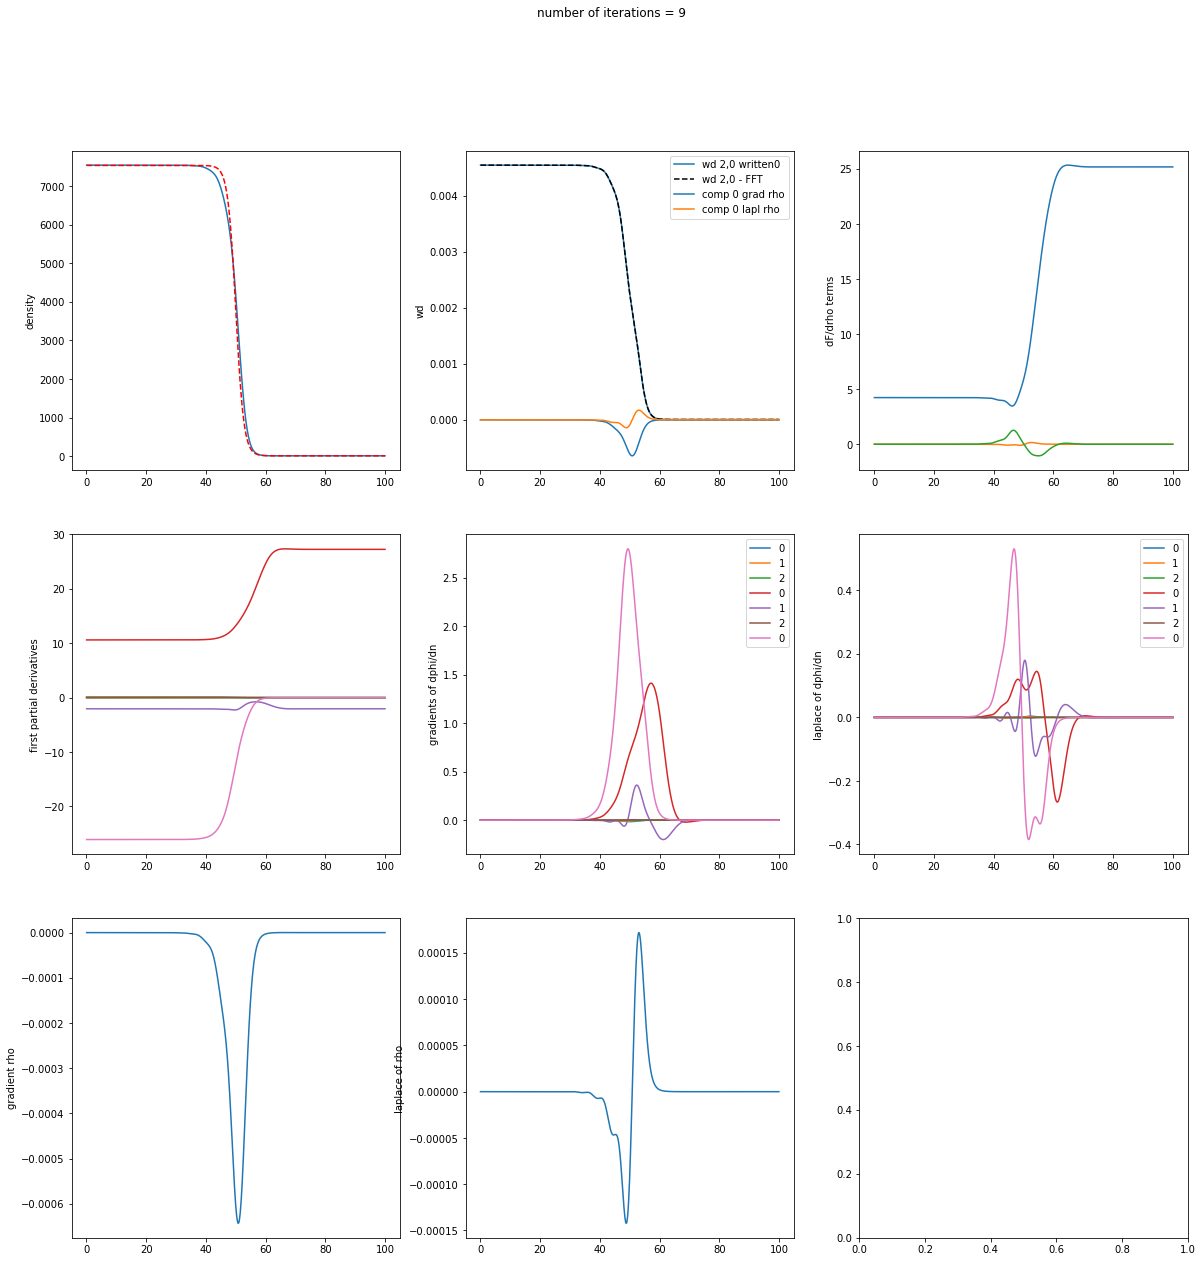

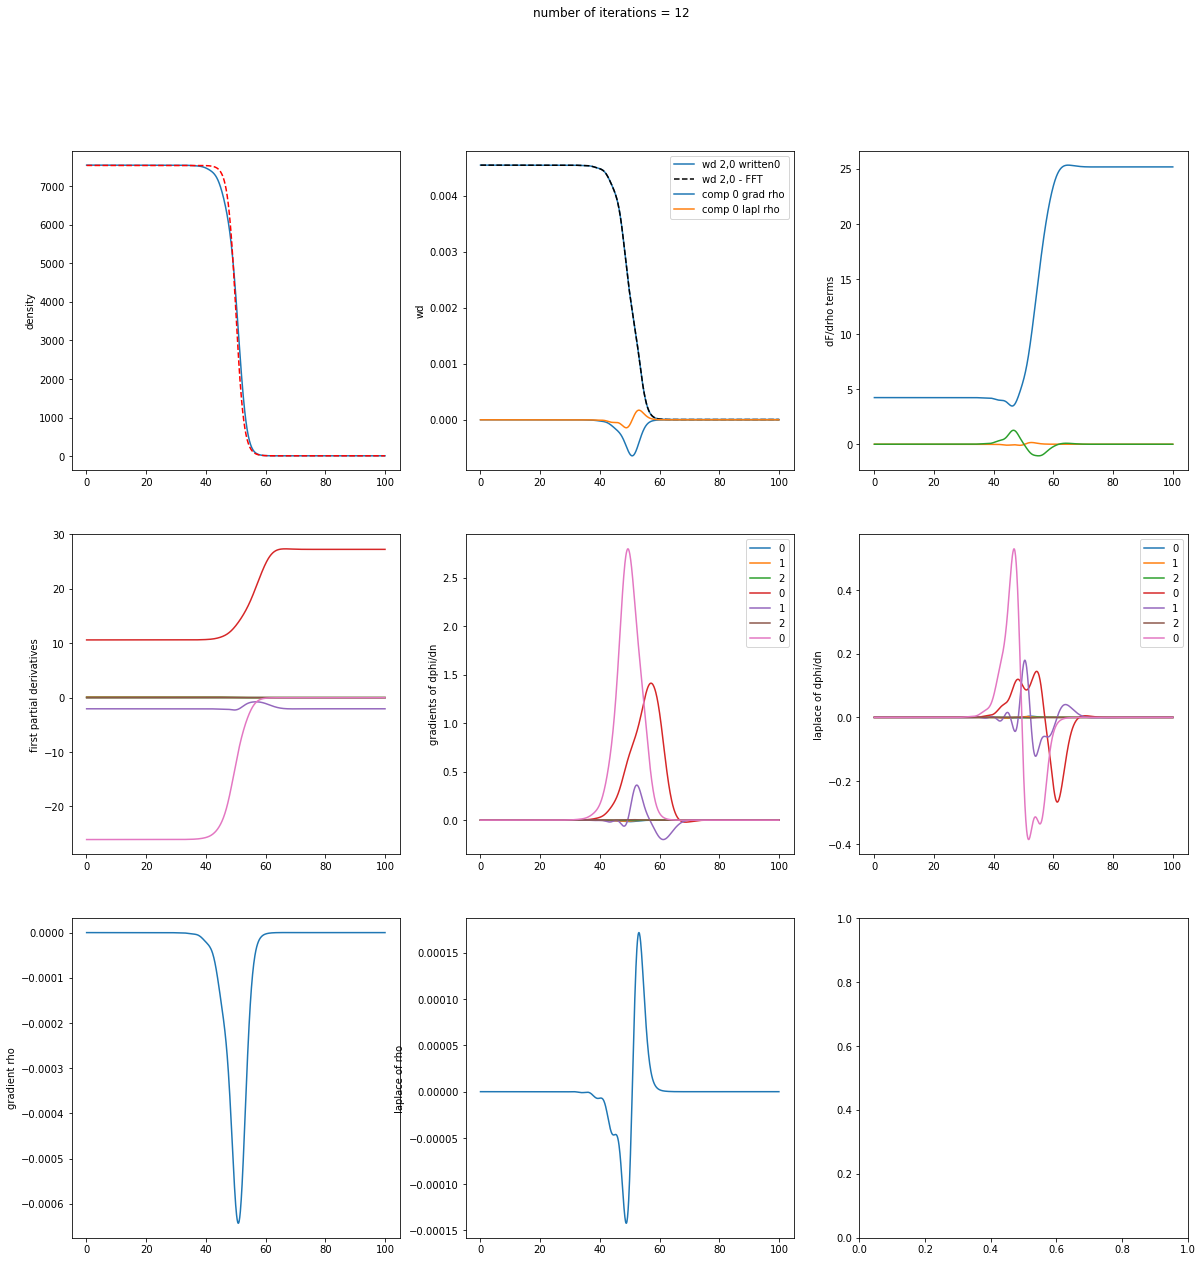

In [49]:
%%time
max_iter_picard = 3
max_iter = 100
imax = 4

solver_pic = DFTSolver(output=True).picard_iteration(tol=1.0e-9, beta=0.01, max_iter=max_iter_picard)#.picard_iteration(tol=1.0e-5, beta=0.01, max_iter=10).anderson_mixing(tol=1.0e-9,mmax=10)# # just write after one another


solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=100, max_iter=max_iter, beta=0.1)# # just write after one another #picard_iteration(tol=1.0e-9, beta=0.03, max_iter=max_iter_picard).
# solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=25, max_iter=max_iter, beta=0.001)# # just write after one anoth
if imax != 0:
    interface = PlanarInterface.from_tanh(vle, 1024, 100 * ANGSTROM, t_crit, local_flag=2)
    density_init = interface.density
i = 0

while i <= imax:
    if i !=0 and i!=1: 
        print('calling solve')
        interface.solve(solver, debug=True)   
    elif i==1:
        print('calling solve picard')
        interface.solve(solver_pic, debug=True)  
    else:
        print('calling initial solve')
        interface.solve(DFTSolver(output=True).picard_iteration(tol=1.0e-9, beta=0.005, max_iter=0), debug=True)
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 20), facecolor='w', edgecolor='k')
    axs[0,0].plot(interface.z / ANGSTROM, (interface.density/MOL*METER**3)[0,:])
    axs[0,0].plot(interface.z / ANGSTROM, (density_init/MOL*METER**3)[0,:], 'r--')
#     axs[0].set_ylim([7537.354, 7537.355])
#     axs[0,0].set_xlim([90,101])
    rho0=(interface.density/MOL*METER**3)[0,-1]
#     axs[0,0].set_ylim([rho0-1e-9,rho0+1e-9])
    axs[0,0].set_ylabel('density')
    

    # axs[3].plot(interface.z / ANGSTROM, (data)[1,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[2,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[3,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[4,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[5,:])
    # axs[3].set_ylim([-0.000001,.000001])
#     axs[0,0].legend()
# #     axs[1,0].set_ylim([-1e-11,1e-11])
#     axs[0,0].set_ylabel('dphi/dn')
    
    
    # axs[0].set_ylim([(interface.density/MOL*METER**3)[0,0]-0.01, (interface.density/MOL*METER**3)[0,0]+0.01])
    # axs[0].set_xlim([0, 20])

  
    for filename in glob.glob('2_wd.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[0,1].plot(interface.z / ANGSTROM, (data)[j,:], label=f'wd 2,0 written{j}')#, marker = 'x')
            
            
    # axs[2,2].set_prop_cycle(None)
    # print('calling weighted densities')
    # for wds in (interface.weighted_densities)[2]:        
    #     axs[0,1].plot(interface.z / ANGSTROM, wds, '--c', label=f'wd2,1- grad_conv prof')
        
        
    axs[0,1].set_prop_cycle(None)
    for wds in (interface.weighted_densities_FFT)[2]:        
        axs[0,1].plot(interface.z / ANGSTROM, wds, '--k', label=f'wd 2,0 - FFT')
    
    
    for filename in glob.glob('*grad_rho.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[0,1].plot(interface.z / ANGSTROM, (data)[j,:], label=f'comp {j} grad rho')#, marker = 'x')
            # print(i)

        
    for filename in glob.glob('*lapl_rho.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[0,1].plot(interface.z / ANGSTROM, (data)[j,:], label=f'comp {j} lapl rho')#, marker = 'x')
            # print(i)
    
    
    axs[0,1].set_ylabel('wd')
    axs[0,1].legend()


#     for filename in glob.glob('2_wd.npy'):
#         data = np.load(filename)    
#         for j in range(data.shape[0]):
#             axs[0,1].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')#, marker = 'x')
#     axs[0,1].set_ylabel('wd')
#     axs[0,1].legend()
    
#     axs[1,0].plot(interface.z / ANGSTROM, (interface.functional_derivative)[0,:])
#     #axs[1].set_ylim([4.2605, 4.26075])
# #     axs[1].set_xlim([60,80])
# #     axs[1].set_ylim([-0.000005,.000005])
#     axs[1,0].set_ylabel('dF/drho')


    
    for filename in glob.glob('fd*.npy'):
        data = np.load(filename)    
        axs[0,2].plot(interface.z / ANGSTROM, (data)[0,:])
    # axs[2].plot(interface.z / ANGSTROM, (interface.weighted_densities)[0][0,:])
    # axs[2].plot(interface.z / ANGSTROM, (interface.weighted_densities)[1][0,:])
    # axs[2].plot(interface.z / ANGSTROM, (interface.weighted_densities)[2][0,:])
    # axs[2].set_ylim([-0.01,.01])    
#     axs[0,2].set_ylim([-0.000005,.000005])
    axs[0,2].set_ylabel('dF/drho terms')
    
    for filename in glob.glob('*_firstpd.npy'):
        # print(filename)
        data = np.load(filename)   
        for j in range(data.shape[0]):
            axs[1,0].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')
    axs[1,0].set_ylabel('first partial derivatives')
    

#     # axs[1,2].set_ylim([-1e-3,1e-3])
    #     axs[1,2].set_xlim([90,101])

#     axs[0,1].set_prop_cycle(None)
#     print('calling weighted densities')
#     for wds in (interface.weighted_densities)[2]:        
#         axs[0,1].plot(interface.z / ANGSTROM, wds, '--k', label=f'0 - profile')
#     #     for k in range(wds.shape[0]):
#     #         axs[0,1].plot(interface.z / ANGSTROM, (wds)[k,:], '--k', label=f'{k} - profile')
#     # #axs[1].set_ylim([4.2605, 4.26075])
# #     axs[1].set_xlim([60,80])
# #     axs[1].set_ylim([-0.000005,.000005])
#     # axs[1,1].set_ylabel('wd from profile')
#     axs[0,1].legend()
 
    
    
    
    for filename in glob.glob('*_grad_fpd.npy'):
        data = np.load(filename)
        for j in range(data.shape[0]):
            axs[1,1].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')
            # print(i)
    # axs[1,1].set_ylim([-1e-3,1e-3])
    axs[1,1].set_ylabel('gradients of dphi/dn')
    axs[1,1].legend()
    
            
                
    for filename in glob.glob('*_lapl_fpd.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[1,2].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')#, marker = 'x')
            # print(i)
            
    # axs[1,2].set_ylim([-1e-3,1e-3])
#     axs[1,2].set_xlim([90,101])
    axs[1,2].set_ylabel('laplace of dphi/dn')
    axs[1,2].legend()

    for filename in glob.glob('*grad_rho.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[2,0].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')#, marker = 'x')
            # print(i)
    axs[2,0].set_ylabel('gradient rho')

        
    for filename in glob.glob('*lapl_rho.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[2,1].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')#, marker = 'x')
            # print(i)
    axs[2,1].set_ylabel('laplace of rho')
    
    
    #############2,2
    

    
    
    ##############end
    
    # print(data)
    fig.suptitle(f'number of iterations = {i*max_iter_picard}')
    fig.show()

    

    i = i + 1

In [32]:
# contrib = 0
# wd_i = 2

# for wds, wdsfft in zip(interface.weighted_densities, interface.weighted_densities_FFT):
#     for i in range(wds.shape[0]):
#         plt.figure(figsize=[12,8])
        
#         plt.plot(interface.z/ANGSTROM, wds[i,:])
#         plt.plot(interface.z/ANGSTROM, wdsfft[i,:], '--')
#         plt.title(f' {i}')
#         # plt.plot(interface.z/ANGSTROM, (interface.weighted_densities_FFT)[contrib][wd_i,:])
#         # plt.plot(interface.z/ANGSTROM, (interface.weighted_densities)[contrib][wd_i,:], '--')        
#         plt.show


In [33]:
# plt.figure(figsize=[15,10])
# plt.plot(interface.z/ANGSTROM, (interface.density/MOL*METER**3)[0])

In [34]:
# plt.figure(figsize=[15,10])
# for filename in glob.glob('*grad_rho.npy'):
#     data_grad = np.load(filename)    
#     for j in range(data_grad.shape[0]):
#         plt.plot(interface.z / ANGSTROM, (data_grad)[j,:], label=f'grad rho- {j}')#, marker = 'x')
#         # print(i)


# for filename in glob.glob('*lapl_rho.npy'):
#     data = np.load(filename)    
#     for j in range(data.shape[0]):
#         plt.plot(interface.z / ANGSTROM, (data)[j,:], label=f'lapl-rho -{j}')#, marker = 'x')
#         # print(i)
# dz = (interface.z[1]-interface.z[0]) / ANGSTROM
# # plt.plot(interface.z / ANGSTROM, np.gradient(data_grad[0,:], dz))
# plt.plot(interface.z / ANGSTROM, np.gradient((interface.density/MOL*METER**3/1000000)[0,:], dz))
# plt.plot(interface.z / ANGSTROM, np.gradient(np.gradient((interface.density/MOL*METER**3/1000000)[0,:], dz), dz))
# plt.legend()

called fn weighted densities in FFT convolver


(1, 1024)

 Called fn weighted_densities in GradConvolver


surface tension DFT = 17.79337478240941 mN/m
surface tension local DFT = 15.52885853139365 mN/m
Version with total moles
surface tension initial profile = None


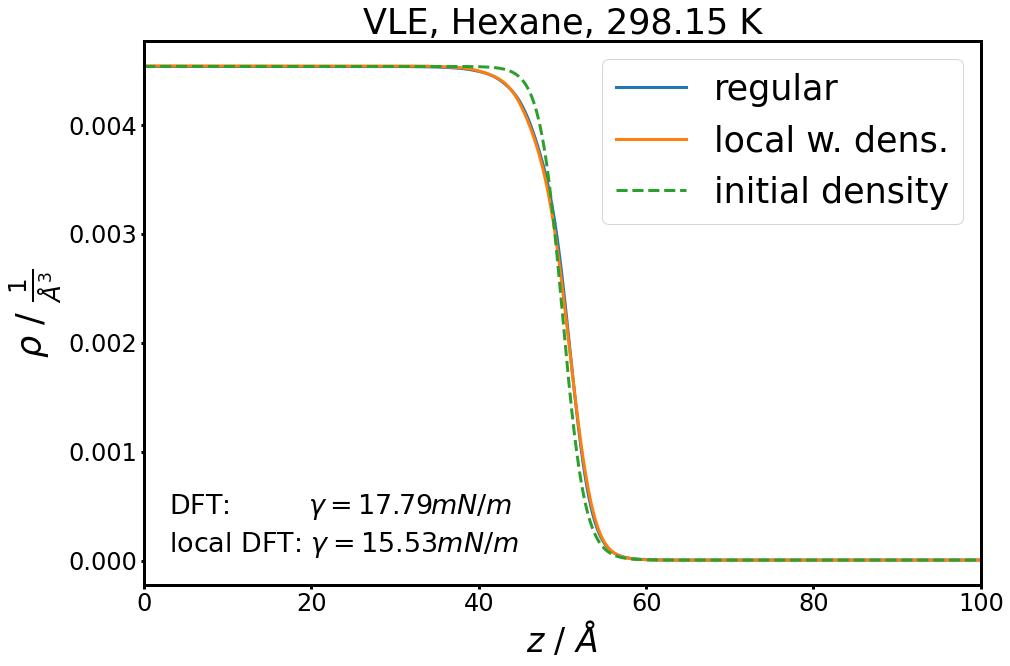

In [54]:
plt_1 = plt.figure(figsize=(15, 10))
fontsize=35
ax = plt.gca()
plt.plot(interface1.z / ANGSTROM, (interface1.density*NAV*ANGSTROM**3)[0,:], label='regular', linewidth=3)#, marker='x')
plt.plot(interface.z / ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='local w. dens.', linewidth=3)
plt.plot(interface.z / ANGSTROM, (density_init*NAV*ANGSTROM**3)[0,:], '--', label = 'initial density', linewidth=3)
plt.legend(fontsize=fontsize)
plt.title(f'VLE, Hexane, {temperature/KELVIN} K', fontsize=fontsize)
plt.ylabel(r'$\rho$ / $\frac{1}{\AA^3}$', fontsize=fontsize)
plt.xlabel(r'$z$ / $\AA$', fontsize=fontsize-2)
plt.xlim([0,100])

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=20)


plt.text(0.03, 0.13, s=fr'DFT:         $\gamma = {interface1.surface_tension/MILLI/NEWTON*METER:.2f} mN/m$', transform=ax.transAxes, fontsize=fontsize-8)
plt.text(0.03, 0.06, s=fr'local DFT: $\gamma = {interface.surface_tension/MILLI/NEWTON*METER:.2f} mN/m$', transform=ax.transAxes, fontsize=fontsize-8)

print(f'surface tension DFT = {interface1.surface_tension}')
print(f'surface tension local DFT = {interface.surface_tension}')
interface_init = PlanarInterface.from_tanh(vle, 1024, 100 * ANGSTROM, t_crit, local_flag=True)
print(f'surface tension initial profile = {interface_init.surface_tension}')
plt.savefig('rho_DFTvsloc_wdgrad_font.png')

Version with total moles
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
solver               | iter | residual 
-------------------------------------------
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
Anderson mixing      |    1 | 3.335799e-4 
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
Anderson mixing      |    2 | 2.810479e-4 
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
Anderson mixing      |    3 | 8.057937e-5 
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
Anderson mixing      |    4 | 4.856455e-5 
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
Anderson mixing      |    5 | 2.901953e-5 
called fn weighted densities in FFT convolver
called fn weighted densities in FFT convolver
Anderson mixing      |    6 | 1.

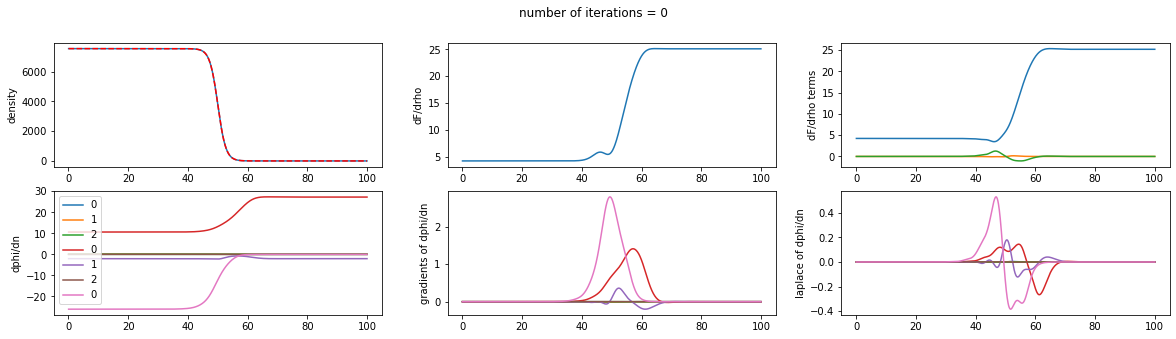

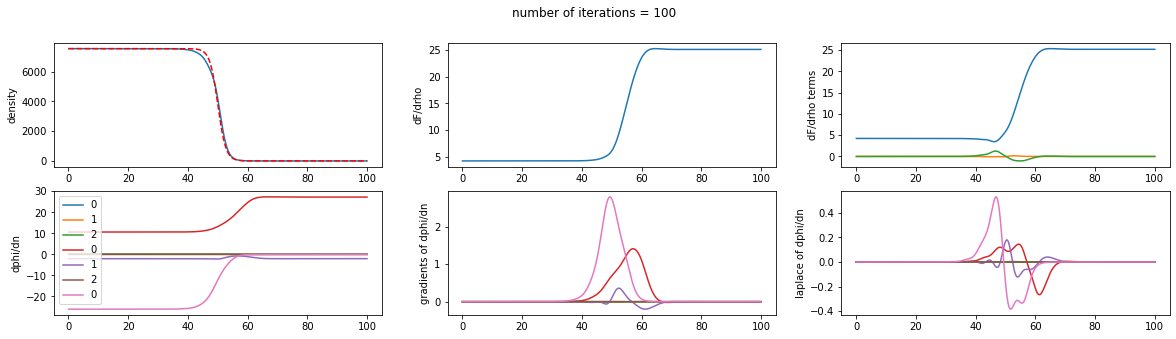

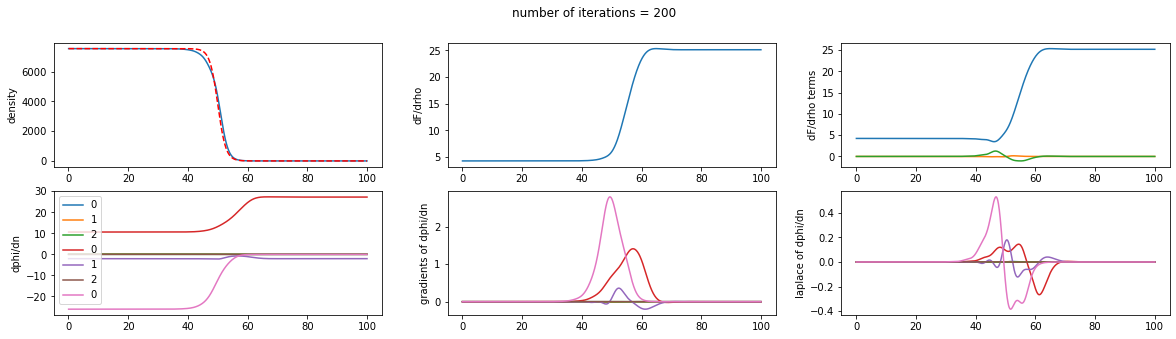

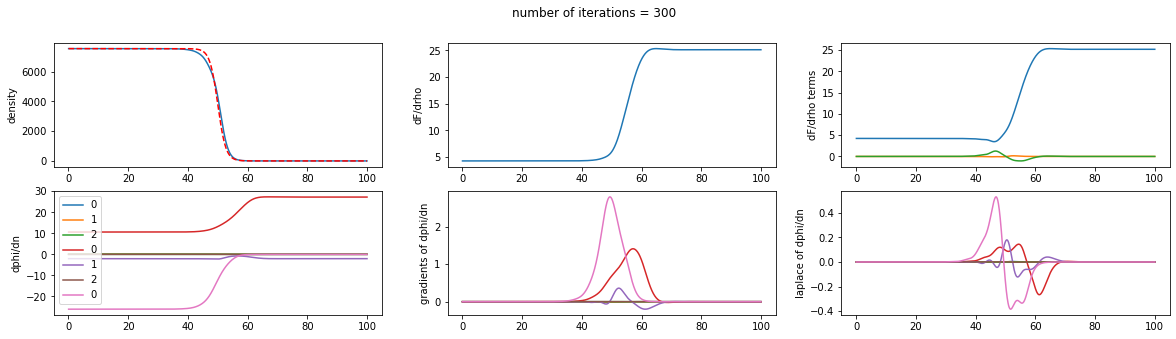

In [35]:
%%time
max_iter = 100
imax = 3

# solver = DFTSolver(output=True).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=max_iter)#.picard_iteration(tol=1.0e-5, beta=0.01, max_iter=10).anderson_mixing(tol=1.0e-9,mmax=10)# # just write after one another


solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=25, max_iter=max_iter, beta=0.03)# # just write after one another
interface1 = PlanarInterface.from_tanh(vle, 1024, 100 * ANGSTROM, t_crit, local_flag=0)
density_init = interface1.density
i = 0

while i <= imax:
    if i !=0: interface1.solve(solver, debug=True)    
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
    axs[0,0].plot(interface1.z / ANGSTROM, (interface1.density/MOL*METER**3)[0,:])
    axs[0,0].plot(interface1.z / ANGSTROM, (density_init/MOL*METER**3)[0,:], 'r--')
#     axs[0].set_ylim([7537.354, 7537.355])
#     axs[0,0].set_xlim([90,101])
    rho0=(interface1.density/MOL*METER**3)[0,-1]
#     axs[0,0].set_ylim([rho0-1e-9,rho0+1e-9])
    axs[0,0].set_ylabel('density')
    
    
    # axs[0].set_ylim([(interface1.density/MOL*METER**3)[0,0]-0.01, (interface1.density/MOL*METER**3)[0,0]+0.01])
    # axs[0].set_xlim([0, 20])

    axs[0,1].plot(interface1.z / ANGSTROM, (interface1.functional_derivative)[0,:])
    #axs[1].set_ylim([4.2605, 4.26075])
#     axs[1].set_xlim([60,80])
#     axs[1].set_ylim([-0.000005,.000005])
    axs[0,1].set_ylabel('dF/drho')


    
    for filename in glob.glob('fd*.npy'):
        data = np.load(filename)    
        axs[0,2].plot(interface1.z / ANGSTROM, (data)[0,:])
    # axs[2].plot(interface1.z / ANGSTROM, (interface1.weighted_densities)[0][0,:])
    # axs[2].plot(interface1.z / ANGSTROM, (interface1.weighted_densities)[1][0,:])
    # axs[2].plot(interface1.z / ANGSTROM, (interface1.weighted_densities)[2][0,:])
    # axs[2].set_ylim([-0.01,.01])    
#     axs[0,2].set_ylim([-0.000005,.000005])
    axs[0,2].set_ylabel('dF/drho terms')
    
    
    
    for filename in glob.glob('*_firstpd.npy'):
        # print(filename)
        data = np.load(filename)   
        for j in range(data.shape[0]):
            axs[1,0].plot(interface1.z / ANGSTROM, (data)[j,:], label=f'{j}')
    # axs[3].plot(interface1.z / ANGSTROM, (data)[1,:])
    # axs[3].plot(interface1.z / ANGSTROM, (data)[2,:])
    # axs[3].plot(interface1.z / ANGSTROM, (data)[3,:])
    # axs[3].plot(interface1.z / ANGSTROM, (data)[4,:])
    # axs[3].plot(interface1.z / ANGSTROM, (data)[5,:])
    # axs[3].set_ylim([-0.000001,.000001])
    axs[1,0].legend()
#     axs[1,0].set_ylim([-1e-11,1e-11])
    axs[1,0].set_ylabel('dphi/dn')
    
    
    
    for filename in glob.glob('*_grad_fpd.npy'):
        data = np.load(filename)
        for j in range(data.shape[0]):
            axs[1,1].plot(interface1.z / ANGSTROM, (data)[j,:])
            # print(i)
#     axs[1,1].set_ylim([-0.00000005,.00000005])
    axs[1,1].set_ylabel('gradients of dphi/dn')
    
            
        
    for filename in glob.glob('*_lapl_fpd.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[1,2].plot(interface1.z / ANGSTROM, (data)[j,:])#, marker = 'x')
            # print(i)
            
#     axs[1,2].set_ylim([-1e-3,1e-3])
#     axs[1,2].set_xlim([90,101])
    axs[1,2].set_ylabel('laplace of dphi/dn')
    
    
    # print(data)
    fig.suptitle(f'number of iterations = {i*max_iter}')
    fig.show()
    

    i = i + 1

In [29]:
# plt.plot(interface.z / ANGSTROM, (interface.density/MOL*METER**3)[0,:])
# plt.plot(interface.z / ANGSTROM, (density_init/MOL*METER**3)[0,:], 'r--')


In [30]:
# # plot initial density profile
# plt.plot(interface.z / ANGSTROM, (interface.weighted_densities)[0][1,:])
# plt.plot(interface.z / ANGSTROM, (interface.local_weighted_densities)[0][1,:], 'r--')

In [31]:
# n_comps = len(composition)
# n_wd = sum([len(x) for x in interface.weighted_densities])
# fig, axs = plt.subplots(int(n_wd/n_comps), n_comps,figsize=(15, 40), facecolor='w', edgecolor='k')
# i=0
# #fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()

# for j, (wds, lwds) in enumerate(zip(interface.weighted_densities, interface.local_weighted_densities)):
#     for k, (wd, lwd) in enumerate(zip(wds, lwds)):

#         axs[i].plot(interface.z / ANGSTROM, wd, 'b')
#         axs[i].plot(interface.z / ANGSTROM, lwd, 'r')
#         axs[i].set_title(f'contribution {j}, wd {k}')
#         i = i+1

# #fig.savefig(f'weighted_densities.pdf', )  


 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
4
 Called fn functional_derivative in GradConvolver
 Called fn functional_derivative in GradConvolver
 Called fn functional_derivative in GradConvolver
 Called fn functional_derivative in GradConvolver


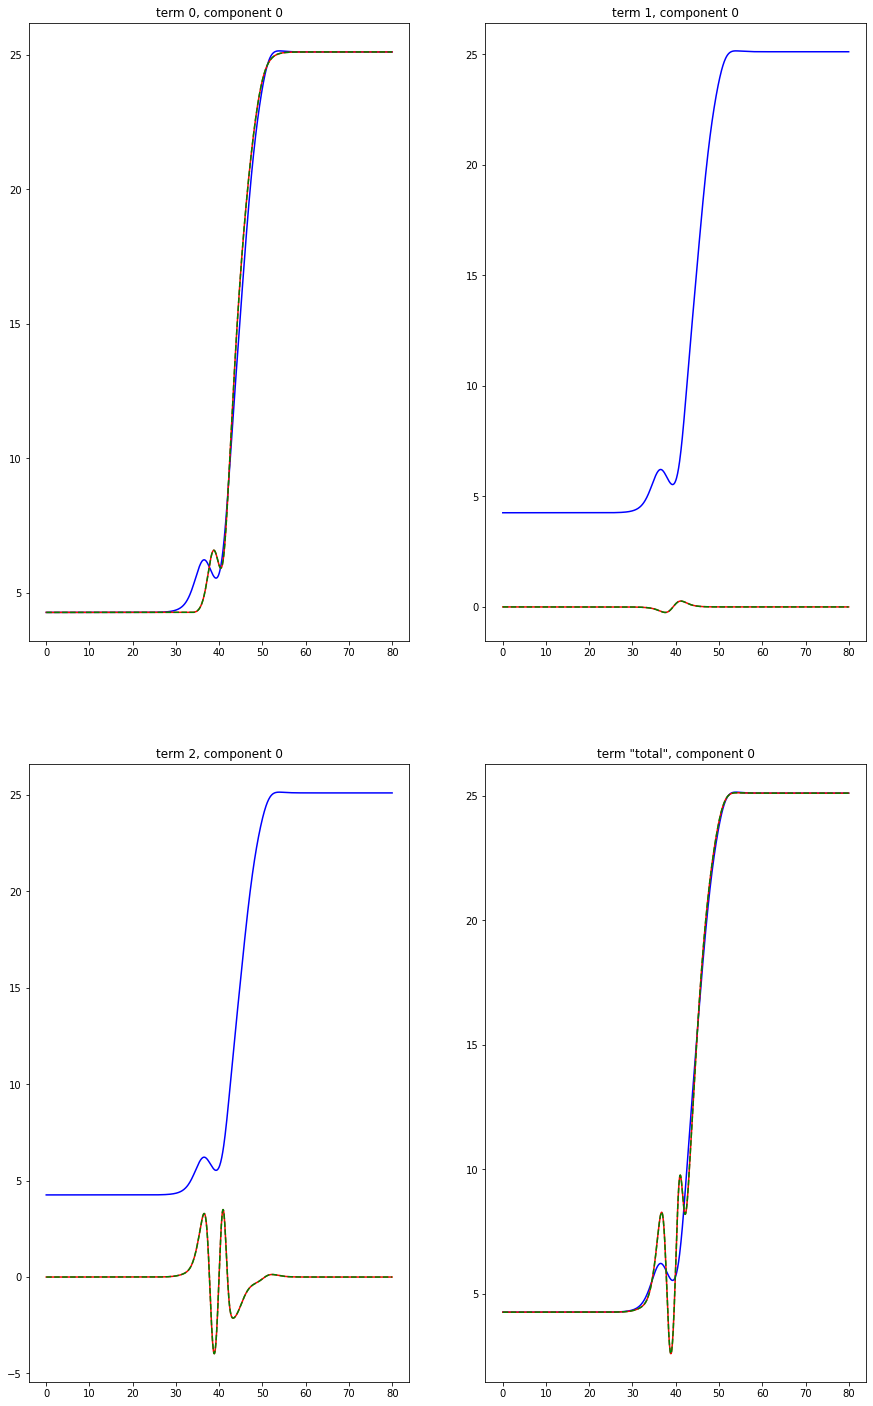

In [32]:
lfds_list = interface.local_functional_derivative
lfds_list.append(sum(interface.local_functional_derivative[0:1], interface.local_functional_derivative[2]))
lfds_list_v2 = interface.local_functional_derivative_v2
lfds_list_v2.append(sum(interface.local_functional_derivative_v2[0:1], interface.local_functional_derivative_v2[2]))


n_comps = len(composition)
n_types = sum([len(x) for x in lfds_list])
print(n_types)

fig, axs = plt.subplots(int(n_types/n_comps), n_comps,figsize=(15, 25), facecolor='w', edgecolor='k')
i=0
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j, (lfds, lfds_v2) in enumerate(zip(lfds_list, lfds_list_v2)):
    for k, (fd, (lfd, lfd_v2)) in enumerate(zip(interface.functional_derivative, zip(lfds, lfds_v2))):

        axs[i].plot(interface.z / ANGSTROM, fd, 'b')
        axs[i].plot(interface.z / ANGSTROM, lfd, 'r')
        axs[i].plot(interface.z / ANGSTROM, lfd_v2, 'g--')
        if j == n_types-1: j = '"total"'
        axs[i].set_title(f'term {j}, component {k}')
        i = i+1

#fig.savefig(f'functional_derivatives.pdf', )  


Version of 8:50
w0 = [[3.0576660000000007, 2.6895279999999993],
 [5.742616691063705, 5.014246501518509],
 [135.53126057971835, 117.47491903605786],
 [84.8472962891734, 73.00515205551848],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [3.595078344122986, 3.1161190089848008],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w2 = [[1.7975391720614928, 1.5580595044924002],
 [3.375966653101143, 2.9047827052028015],
 [79.67605027197781, 68.053916577037],
 [29.927991884652585, 25.375390262606697],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w0 = [[1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [22.588543429953063, 19.579153172676314],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],

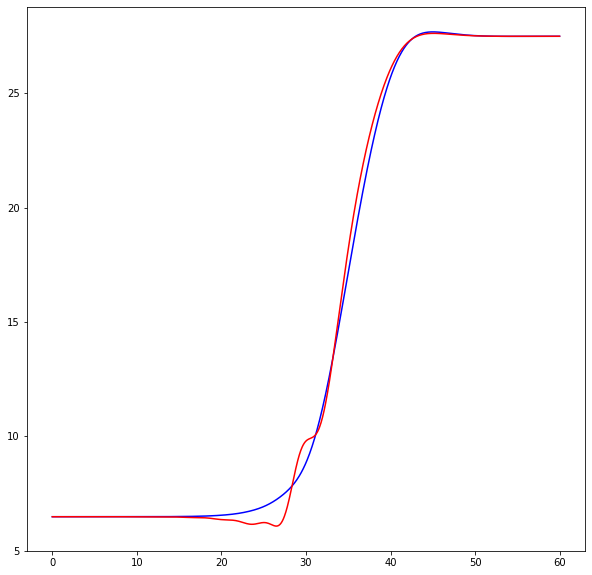

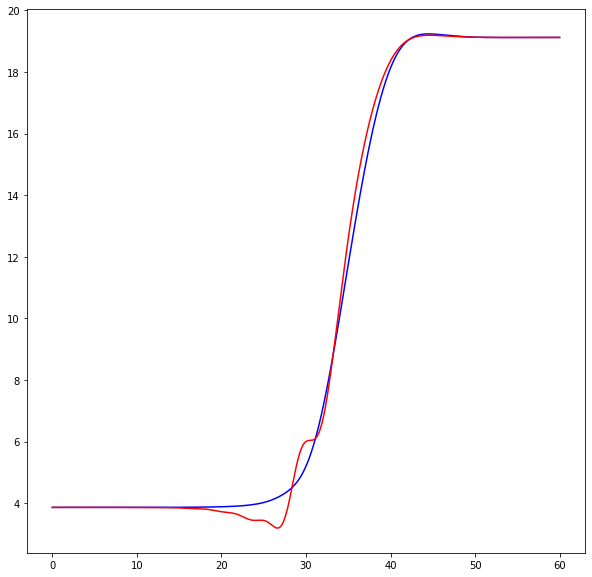

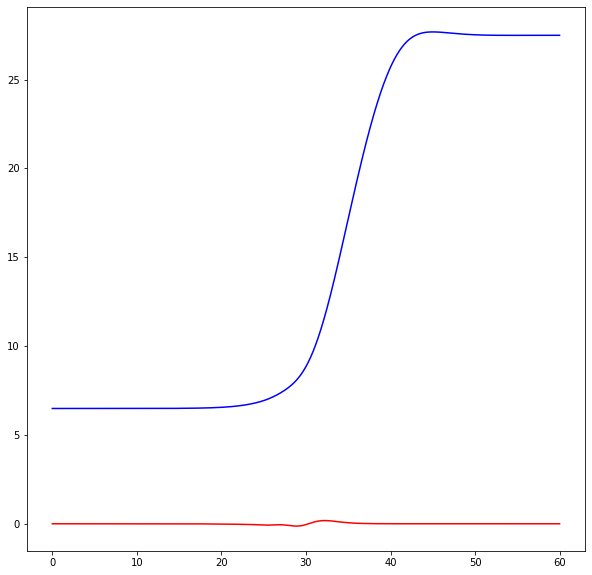

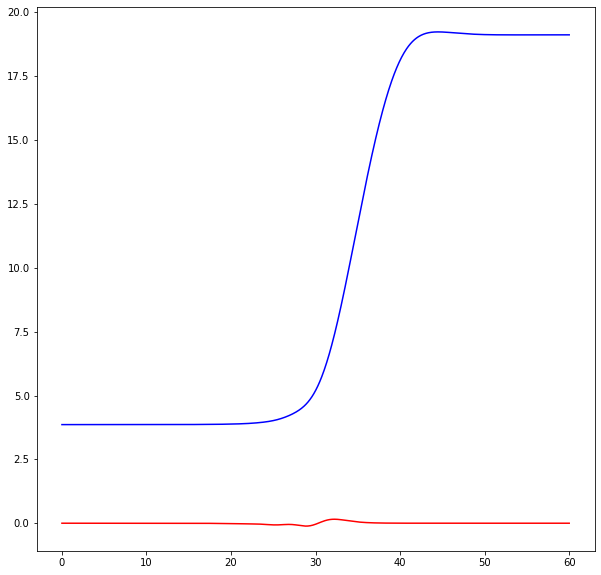

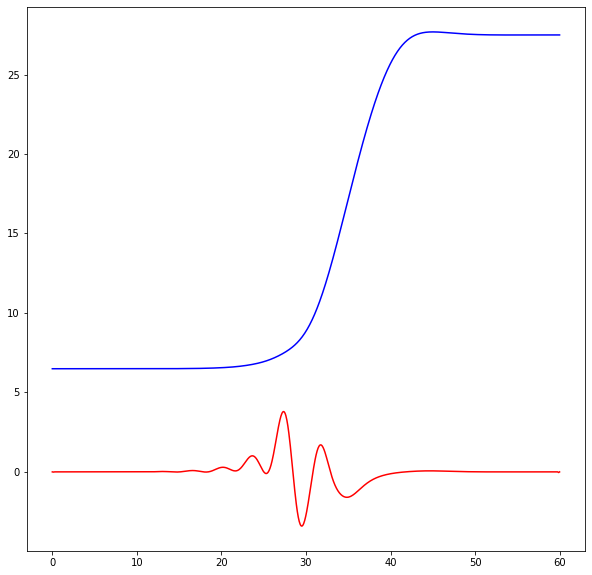

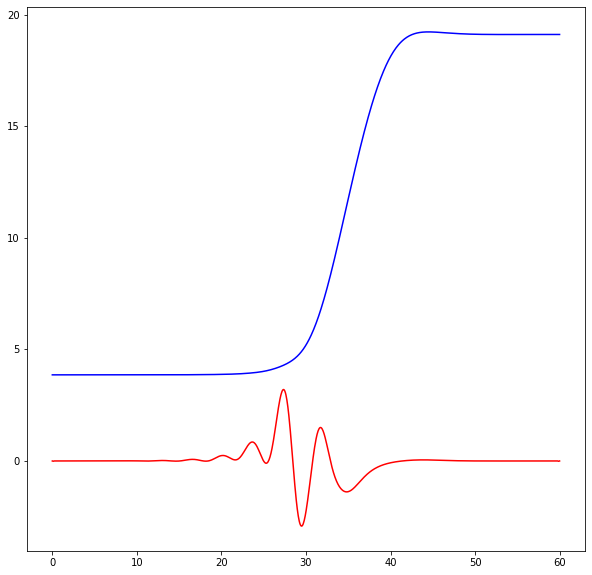

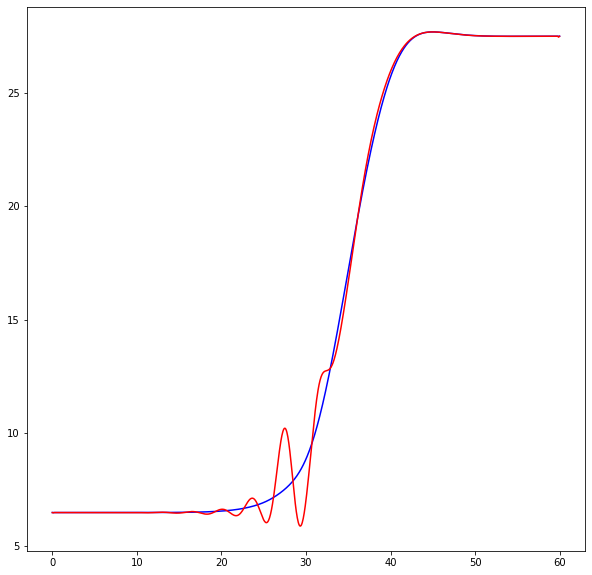

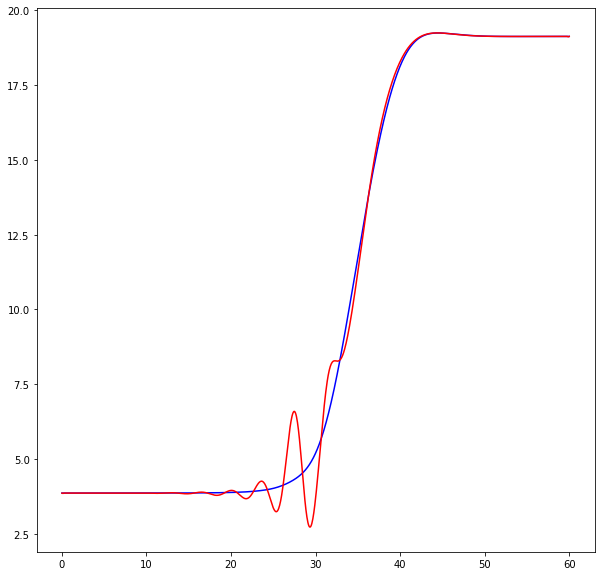

In [37]:
i = 0
i=0
lfds_list = interface.local_functional_derivative
lfds_list.append(sum(interface.local_functional_derivative))

for lfds in lfds_list:
    for fd, lfd in zip(interface.functional_derivative,lfds):
        plt.figure(figsize=(10,10))
        plt.plot(interface.z / ANGSTROM, fd, 'b')
        plt.plot(interface.z / ANGSTROM, lfd, 'r')

    #plt.savefig(f'functional_derivative_{i}.pdf', )  
    i=i+1
    
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

Version of 8:50
w0 = [[3.0576660000000007, 2.6895279999999993],
 [5.742616691063705, 5.014246501518509],
 [135.53126057971835, 117.47491903605786],
 [84.8472962891734, 73.00515205551848],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [3.595078344122986, 3.1161190089848008],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w2 = [[1.7975391720614928, 1.5580595044924002],
 [3.375966653101143, 2.9047827052028015],
 [79.67605027197781, 68.053916577037],
 [29.927991884652585, 25.375390262606697],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w0 = [[1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [22.588543429953063, 19.579153172676314],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],

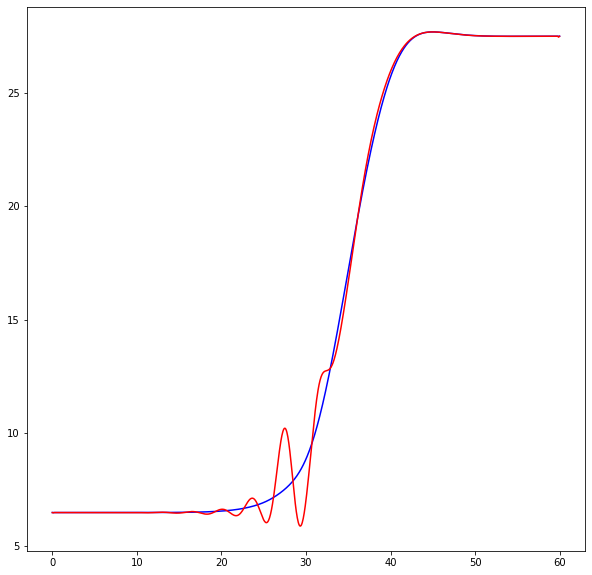

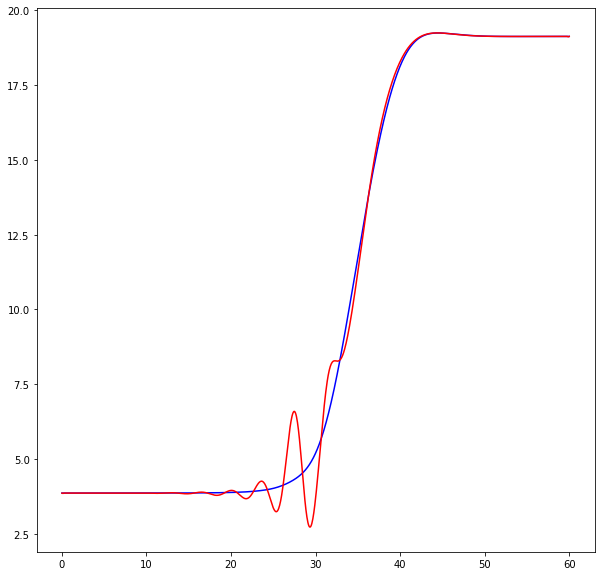

In [51]:
# plot functional derivative
i=0
for fd, lfd in zip(interface.functional_derivative, interface.local_functional_derivative):
    plt.figure(figsize=(10,10))
    plt.plot(interface.z / ANGSTROM, fd, 'b')
    plt.plot(interface.z / ANGSTROM, lfd, 'r')
    
    plt.savefig(f'functional_derivative_{i}.pdf', )  
    i=i+1
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [14]:
wd = interface.weighted_densities
plt.plot(interface.z / ANGSTROM, (wd / MOL * METER**3)[0,:])
print(len(wd))
print(wd[1].shape)

TypeError: not implemented!

## DFT Example

In [10]:
## Planar Interface 

In [11]:
# system specification
components = ['hexane', 'octane'] # ['hexane'] # 
x = 0.3
composition = np.array([x, 1-x])
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [12]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [13]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [14]:
# calculate phase equilibrium
#vle = PhaseEquilibrium.pure_t(func, temperature)
vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition)
vle


||temperature|density|molefracs|
|-|-|-|-|
|phase 1|298.15 K|2.964357865432749  mol/m³|[0.81911, 0.18089]|
|phase 2|298.15 K|6.446506873296946 kmol/m³|[0.30000, 0.70000]|


In [15]:
# calculate critical point (needed for initializiation of tanh profile)
#t_crit = State.critical_point_pure(func)[0].temperature
t_crit = State.critical_point(func, 1 * MOL *composition).temperature
t_crit

568.0769398960161 K

In [16]:
# intialize solver and interface density profile
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

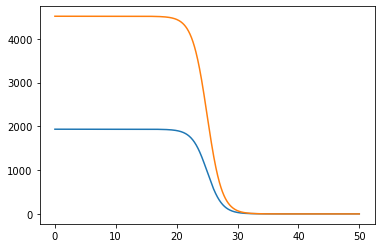

In [17]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [18]:
# solve DFT
interface.solve(solver)

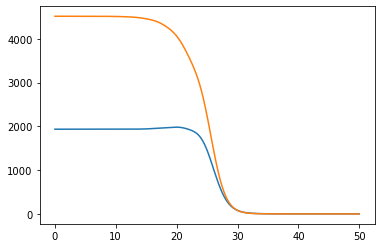

In [19]:
# plot final density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [20]:
# print surface tension
interface.surface_tension

20.13926529391086 mN/m

In [21]:
interface.equimolar_radius

2.4999964243533226 nm

# Adsorption at a wall in 1D

In [16]:
# system specification
components =  ['hexane']#, 'pentane']
x = 0.5
composition = np.array([x, 1-x])
temperature = 250.15* KELVIN
pressure = 1 * BAR

In [17]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [18]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [19]:
# Create State 
state = State(func, temperature, pressure=pressure)#, molefracs=composition)

In [20]:
# create potential 
potential  = ExternalPotential.LJ93(3.0, 150.0, 0.08)
#potential  = ExternalPotential.HardWall(3.1)


In [21]:
#np.array([[5,5]*ANGSTROM,[10,10]*ANGSTROM])

In [32]:
# Create wall as a cartesian (slit) pore with large width --> bulk in the center
wall_profile = Pore1D(func, Geometry.Cartesian, 30*ANGSTROM, potential, 512).initialize(state, local_flag=True)

In [33]:
#(wall_profile.density/MOL*METER**3)[0]

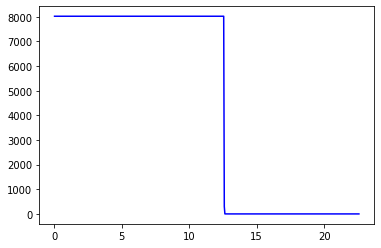

In [42]:
plt.plot(wall_profile.z / ANGSTROM,(wall_profile.density/MOL * METER **3)[0,:], 'b')
# plt.plot(wall_profile.z / ANGSTROM, (wall_profile.density/MOL * METER **3)[1,:], 'r')

 Called fn weighted_densities in GradConvolver
called fn weighted densities in FFT convolver


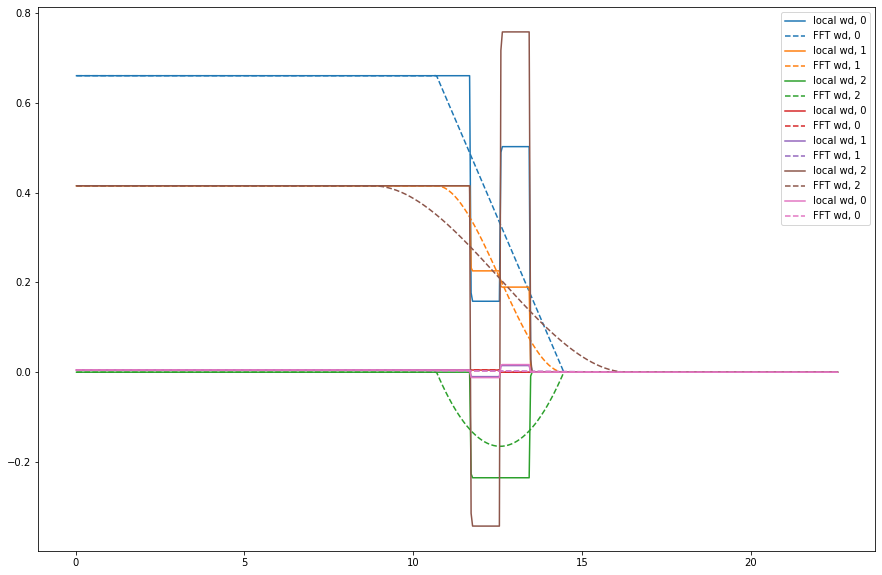

In [46]:
fig = plt.figure(figsize=[15,10])
ax = plt.gca()
for wds, wdsfft in zip(wall_profile.weighted_densities, wall_profile.weighted_densities_FFT):
    for i in range(len(wds)):
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(wall_profile.z/ANGSTROM, wds[i,:], label=f'local wd, {i}', color=color)
        plt.plot(wall_profile.z/ANGSTROM, wdsfft[i,:], label=f'FFT wd, {i}',color=color, linestyle='--')#, marker='x')
plt.legend()


In [45]:
# set solver
solver = DFTSolver(output=False).picard_iteration(beta= 0.001, tol=1.0e-6, max_iter=2)#.anderson_mixing(tol=1.0e-8, max_iter=500, mmax=10)
# solve DFT for wall 
wall_profile.solve(solver, debug=True)

 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver


RuntimeError: `Picard Iteration` encountered illegal values during the iteration.

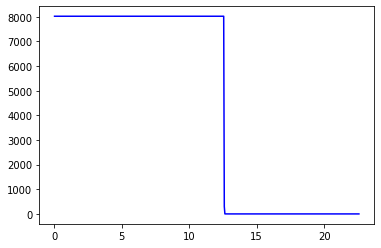

In [47]:
plt.plot(wall_profile.z / ANGSTROM,(wall_profile.density/MOL * METER **3)[0,:], 'b')
# plt.plot(wall_profile.z / ANGSTROM, (wall_profile.density/MOL * METER **3)[1,:], 'r')

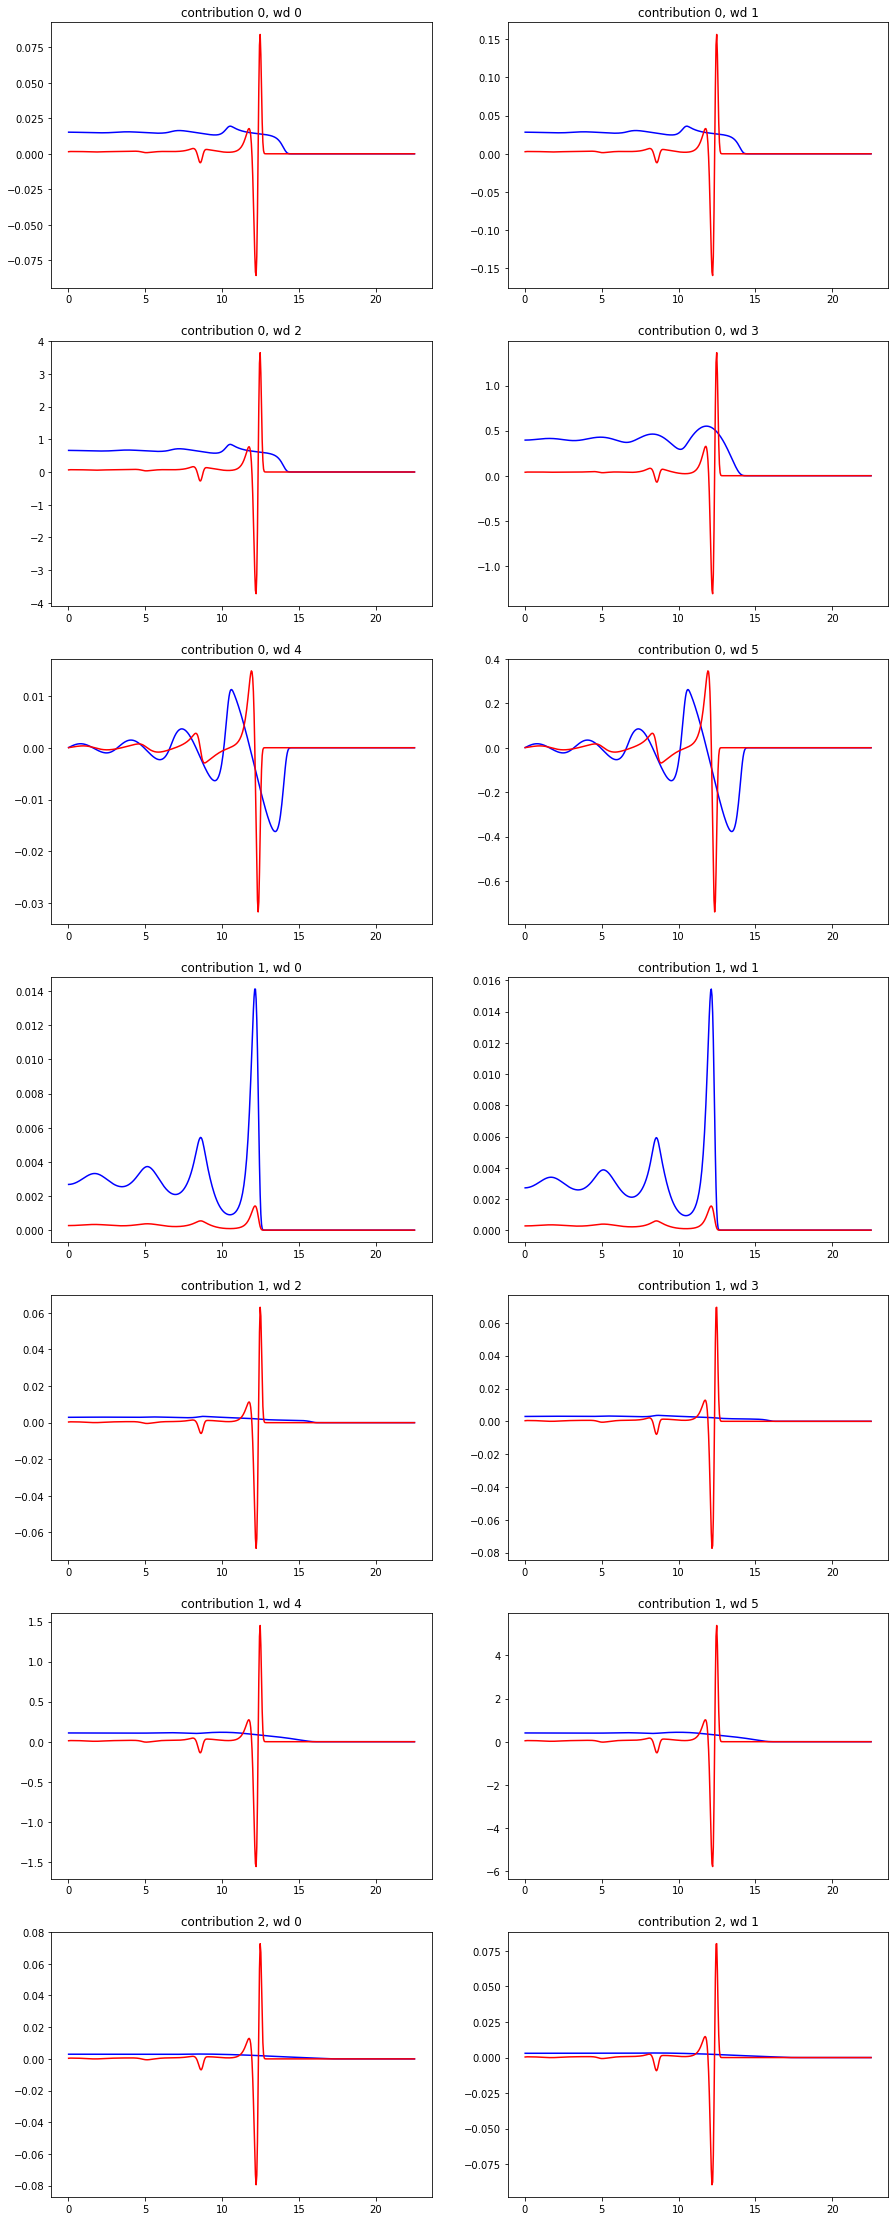

In [67]:
n_comps = len(composition)
n_wd = sum([len(x) for x in wall_profile.weighted_densities])
fig, axs = plt.subplots(int(n_wd/n_comps), n_comps,figsize=(15, 40), facecolor='w', edgecolor='k')
i=0
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j, (wds, lwds) in enumerate(zip(wall_profile.weighted_densities, wall_profile.local_weighted_densities)):
    for k, (wd, lwd) in enumerate(zip(wds, lwds)):

        axs[i].plot(wall_profile.z / ANGSTROM, wd, 'b')
        axs[i].plot(wall_profile.z / ANGSTROM, lwd/10, 'r')
        axs[i].set_title(f'contribution {j}, wd {k}')
        i = i+1

#fig.savefig(f'weighted_densities.pdf', )  


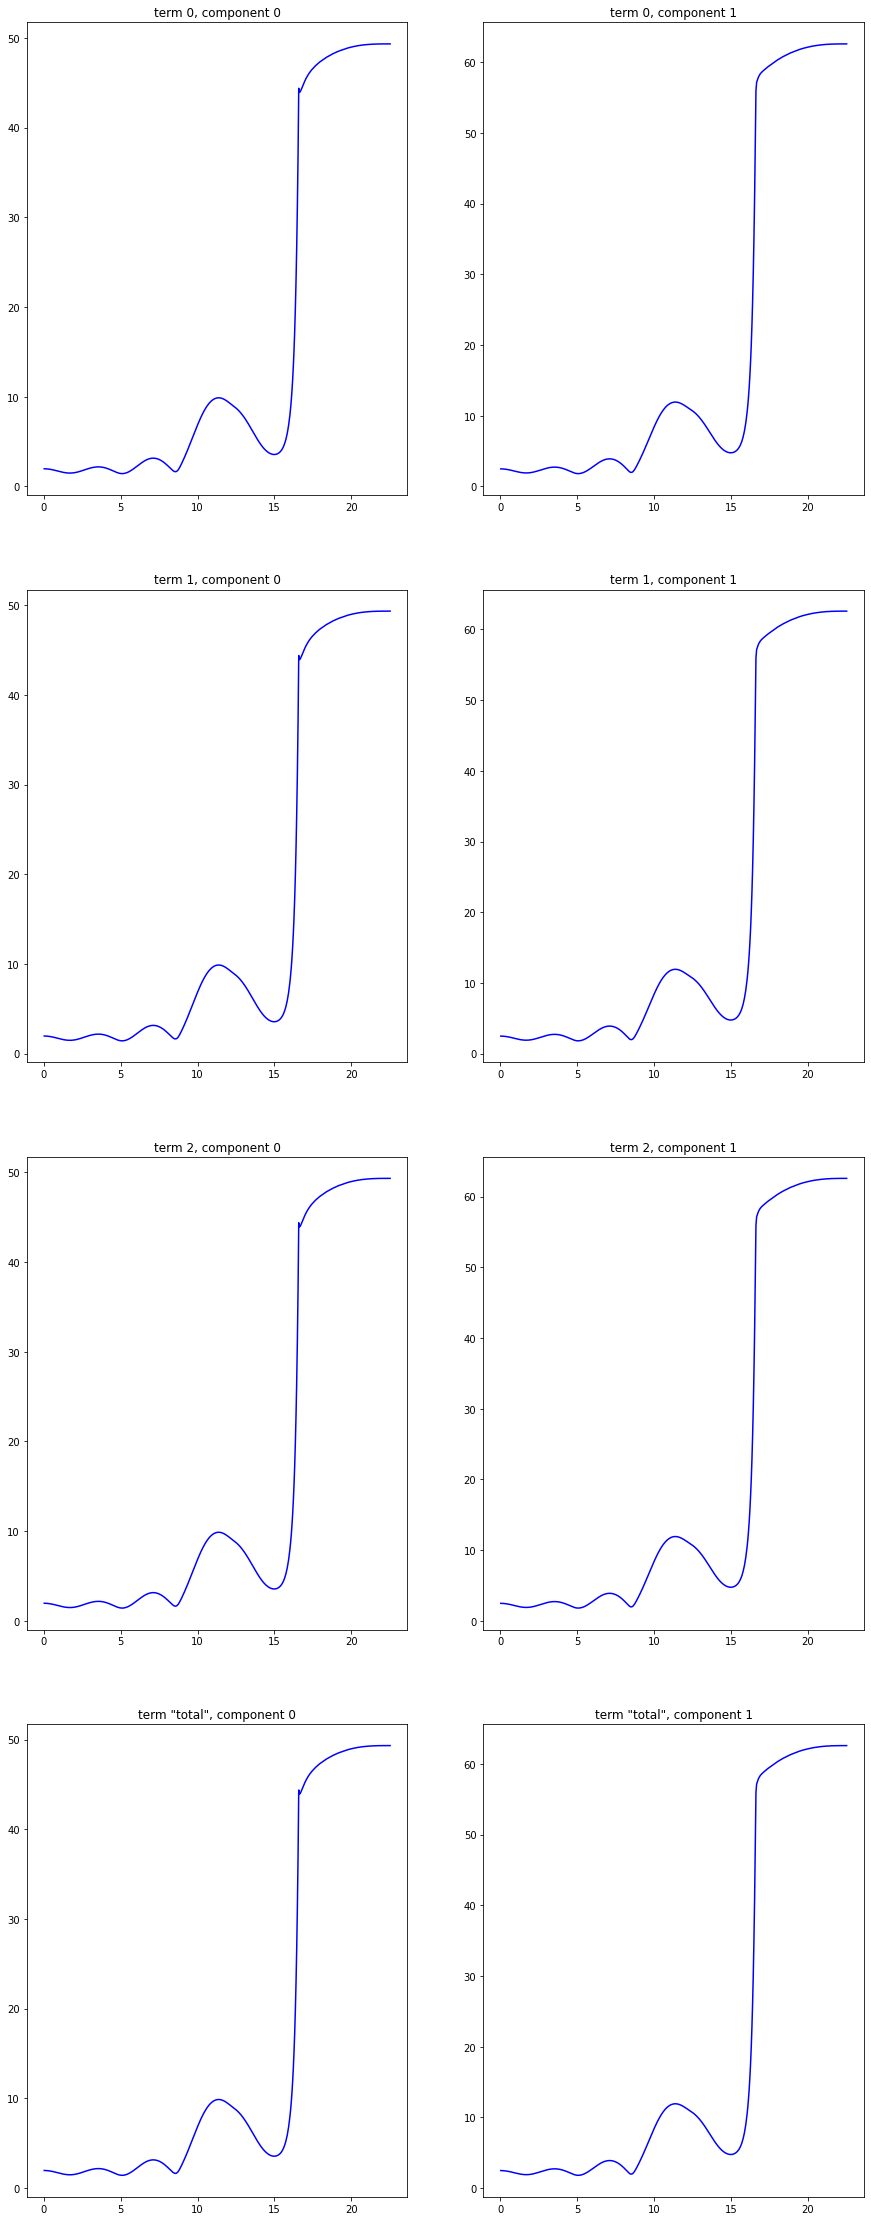

In [68]:
lfds_list = wall_profile.local_functional_derivative
lfds_list.append(sum(wall_profile.local_functional_derivative))
n_comps = len(composition)
n_types = sum([len(x) for x in lfds_list])


fig, axs = plt.subplots(int(n_types/n_comps), n_comps,figsize=(15, 40), facecolor='w', edgecolor='k')
i=0
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j, lfds in enumerate(lfds_list):
    for k, (fd, lfd) in enumerate(zip(wall_profile.functional_derivative, lfds)):

        axs[i].plot(wall_profile.z / ANGSTROM, fd, 'b')
        #axs[i].plot(wall_profile.z / ANGSTROM, lfd, 'r')
        if j == n_types/n_comps-1: j = '"total"'
        axs[i].set_title(f'term {j}, component {k}')
        i = i+1

fig.savefig(f'functional_derivatives.pdf', )  
wall_profile

solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 1.900411e-2 | 0.00000000000024602814176214287
Picard iteration     |    2 | 1.831382e-3 | 0.000000000004274750352979447
Picard iteration     |    3 | 4.250307e-3 | 0.0000000000022339795755648746
Picard iteration     |    4 | 2.481974e-3 | 0.00000000008653019396557015
Picard iteration     |    5 | 2.927275e-3 | 0.000000000013387153513127516
Picard iteration     |    6 | 2.249968e-3 | 0.00000000024703235354477503
Picard iteration     |    7 | 3.635263e-3 | 0.000000000053351598718656106
Picard iteration     |    8 | 2.721452e-3 | 0.0000000064322858048930995
Picard iteration     |    9 | 1.793618e-3 | 0.0000000003494042624676951
Picard iteration     |   10 | 1.789260e-3 | 0.0000000019162773703445335
Picard iteration     |   11 | 3.448593e-3 | 0.0000000009298832337076766
Picard iteration     |   12 | 2.809227e-3 | 0.00000014021139231029337
Picard iteration     |   13 | 1.738614e

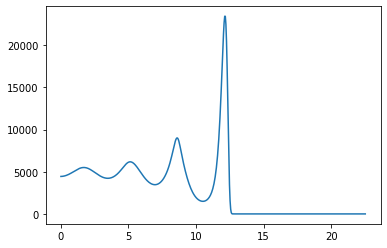

In [27]:
# plot resulting density profile
plt.plot(wall_profile.z/ANGSTROM, (wall_profile.density/MOL*METER**3)[0,:])

In [ ]:
wall_profile.density/MOL*METER**3